# Notebook 3 — EMD decomposition (one series) + saved figure

Этот ноутбук:
1) загружает один ряд из `data/final_features_all.parquet` (по умолчанию `I_t` для AAPL);
2) делает EMD-разложение (IMFs);
3) сохраняет **одну** картинку в `outputs/emd_<ticker>_<series>.png`;
4) печатает таблицу с долей дисперсии (energy) по IMF — удобно для интерпретации.


In [1]:
# (Опционально) ставим PyEMD, если нет
import importlib, sys, subprocess

def pip_install(pkgs):
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q"] + pkgs)

try:
    from PyEMD import EMD
except Exception:
    pip_install(["EMD-signal"])  # пакет PyEMD часто ставится так
    from PyEMD import EMD

import warnings
warnings.filterwarnings("ignore")

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

OUT_DIR = Path("outputs")
OUT_DIR.mkdir(exist_ok=True)

DATA_DIR = Path("data")


In [2]:
# --- Robust parquet loader (как в Notebook 2) ---
_PARQUET_ENGINE = None
try:
    import fastparquet  # noqa: F401
    _PARQUET_ENGINE = "fastparquet"
except Exception:
    _PARQUET_ENGINE = "pyarrow"

def _reset_pyarrow_pandas_ext_types():
    try:
        import pyarrow as pa
    except Exception:
        return
    for name in ("pandas.period", "pandas.interval"):
        try:
            pa.unregister_extension_type(name)
        except Exception:
            pass

def safe_read_parquet(path: Path) -> pd.DataFrame:
    try:
        return pd.read_parquet(path, engine=_PARQUET_ENGINE)
    except Exception as e:
        msg = str(e)
        if ("type extension with name pandas." in msg and "already defined" in msg) or "ArrowKeyError" in msg:
            _reset_pyarrow_pandas_ext_types()
            return pd.read_parquet(path, engine=_PARQUET_ENGINE)
        raise

print("Parquet engine:", _PARQUET_ENGINE)


Parquet engine: pyarrow


In [3]:

# --- Choose series for EMD (prefer intraday if available) ---
from pathlib import Path

ticker = "AAPL"  # поменяйте при желании

intr_path = DATA_DIR / "final_features_intraday_1h.parquet"
if intr_path.exists():
    df = safe_read_parquet(intr_path).copy()
    df["datetime"] = pd.to_datetime(df["datetime"])
    df = df.sort_values(["ticker","datetime"]).reset_index(drop=True)

    series_name = "I_h"
    time_col = "datetime"

    g = df[df["ticker"] == ticker].copy().sort_values(time_col)

    # для EMD нужен регулярный ряд → используем весь часовой грид из цен; I_h заполняем нулями в часы без новостей
    if series_name in g.columns:
        g[series_name] = pd.to_numeric(g[series_name], errors="coerce").fillna(0.0)
    else:
        raise RuntimeError(f"'{series_name}' not found in intraday dataset")

    print("EMD on intraday series:", ticker, series_name, "rows:", len(g), "range:", g[time_col].min(), g[time_col].max())

else:
    # fallback: daily
    df = safe_read_parquet(DATA_DIR / "final_features_all_extended.parquet").copy()
    df["date"] = pd.to_datetime(df["date"])
    df = df.sort_values(["ticker","date"]).reset_index(drop=True)

    series_name = "I_t"
    time_col = "date"

    g = df[df["ticker"] == ticker].copy().sort_values(time_col)
    g[series_name] = pd.to_numeric(g[series_name], errors="coerce").fillna(0.0)

    print("EMD on daily series:", ticker, series_name, "rows:", len(g), "range:", g[time_col].min(), g[time_col].max())

x = g[series_name].to_numpy(dtype=float)


EMD on intraday series: AAPL I_h rows: 8274 range: 2024-01-02 09:00:00 2025-12-29 14:30:00


In [4]:
# --- Run EMD ---
emd = EMD()
imfs = emd.emd(x)

if imfs is None or len(imfs) == 0:
    raise RuntimeError("EMD returned no IMFs (series might be too short/flat).")

imfs = np.asarray(imfs)
residual = x - imfs.sum(axis=0)

print("IMFs:", imfs.shape[0], "len:", imfs.shape[1])

# Energy share per IMF (variance-based)
energies = np.var(imfs, axis=1)
total = float(np.var(x))
share = energies / total if total > 0 else np.nan

energy_tbl = pd.DataFrame({
    "imf": [f"IMF{i+1}" for i in range(imfs.shape[0])],
    "var_share": share
}).sort_values("imf")

energy_tbl


# --- Variance share per IMF ---
var_x = np.var(x)
var_shares = [float(np.var(imfs[i]) / var_x) if var_x > 0 else np.nan for i in range(imfs.shape[0])]
var_tbl = pd.DataFrame({'imf': list(range(1, len(var_shares)+1)), 'var_share': var_shares})
var_tbl.to_csv(OUT_DIR / f"emd_varshare_{ticker}_{series_name}.csv", index=False)
var_tbl.head()


IMFs: 10 len: 8274


,imf,var_share
0,1,4.326862
1,2,3.199693
2,3,3.942234
3,4,0.532817
4,5,0.230224


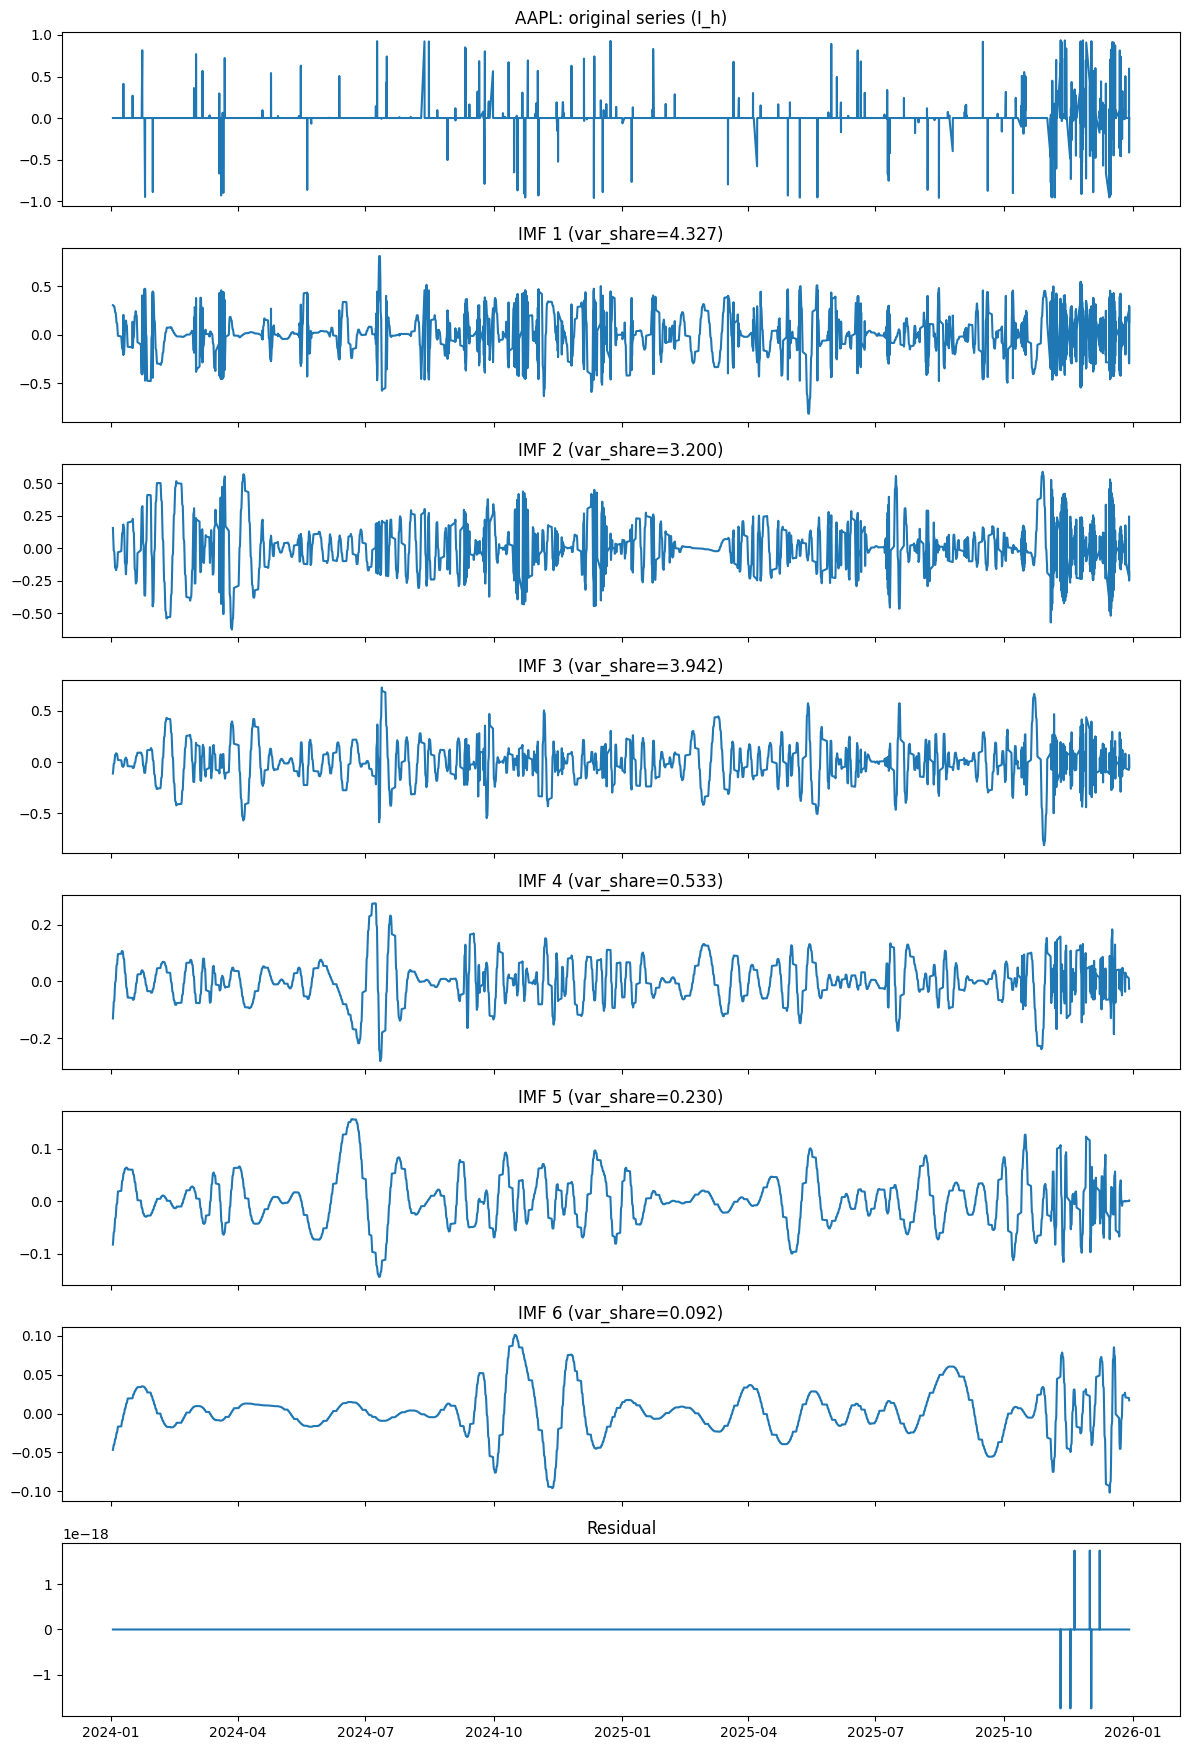

Saved: outputs/emd_AAPL_I_h.png


In [6]:
# --- Plot (ONE figure) and save ---
# Fix: в intraday-режиме у вас колонка может называться "datetime", а не "date".
# Эта версия работает и для daily, и для intraday.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

n_imf = imfs.shape[0]
n_show = min(6, n_imf)  # показываем до 6 IMFs

n_rows = 2 + n_show  # original + IMFs + residual
fig, axes = plt.subplots(n_rows, 1, figsize=(12, 2.2 * n_rows), sharex=True)

# ✅ универсальная ось времени
if "date" in g.columns:
    tvals = pd.to_datetime(g["date"])
elif "datetime" in g.columns:
    tvals = pd.to_datetime(g["datetime"])
else:
    # fallback: индекс
    tvals = pd.to_datetime(g.index)

tvals = tvals.dt.tz_localize(None) if getattr(tvals.dt, "tz", None) is not None else tvals
tvals = tvals.values

axes[0].plot(tvals, x)
axes[0].set_title(f"{ticker}: original series ({series_name})")

# ✅ безопасно достаём var_share (если вдруг строки нет)
def _get_var_share(i: int) -> float:
    key = f"IMF{i+1}"
    try:
        return float(energy_tbl.loc[energy_tbl["imf"] == key, "var_share"].iloc[0])
    except Exception:
        return float("nan")

for i in range(n_show):
    axes[i + 1].plot(tvals, imfs[i])
    vs = _get_var_share(i)
    if np.isfinite(vs):
        axes[i + 1].set_title(f"IMF {i+1} (var_share={vs:.3f})")
    else:
        axes[i + 1].set_title(f"IMF {i+1}")

axes[n_show + 1].plot(tvals, residual)
axes[n_show + 1].set_title("Residual")

fig.tight_layout()
out_path = OUT_DIR / f"emd_{ticker}_{series_name}.png"
fig.savefig(out_path, dpi=150)
plt.show()

print("Saved:", out_path)

